# Environtment Setup

In [1]:
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import random
import math
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
print("TensorFlow version: ", tf.__version__)
print("Keras version: ", keras. __version__)

TensorFlow version:  2.17.1
Keras version:  3.5.0


# Exploratory Data Analysis

In [3]:
# Download Dataset from kaggle using API key
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexandroaurellino
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data


100%|██████████| 75.7M/75.7M [00:00<00:00, 141MB/s]


In [4]:
# Directories
data_dir = "/content/potato-plant-diseases-data/PlantVillage/PlantVillage"
output_dir = "/content/split_potato_dataset"
classes = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

In [5]:
# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [6]:
# Create output directories
for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

In [7]:
# Adjusted splitting logic for exact allocation
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.lower().endswith((".jpg", ".png", ".jpeg"))]

    # Debugging: Check loaded images
    if len(images) == 0:
        print(f"Warning: No images found in {cls_dir}. Check the directory or file extensions.")
        continue

    print(f"Processing {len(images)} images for class '{cls}'...")

    # Exact split calculations
    n_total = len(images)
    n_test = math.floor(n_total * test_ratio)
    n_val = math.floor(n_total * val_ratio)
    n_train = n_total - n_test - n_val

    test = images[:n_test]
    val = images[n_test:n_test + n_val]
    train = images[n_test + n_val:]

    # Move files
    for split, split_images in zip(["train", "val", "test"], [train, val, test]):
        for img in split_images:
            shutil.copy(img, os.path.join(output_dir, split, cls))

Processing 1000 images for class 'Potato___Early_blight'...
Processing 1000 images for class 'Potato___Late_blight'...
Processing 152 images for class 'Potato___healthy'...


In [8]:
# Directories for train, validation, and test splits
train_dir = "/content/split_potato_dataset/train"
val_dir = "/content/split_potato_dataset/val"
test_dir = "/content/split_potato_dataset/test"

In [9]:
# Function to print total images for each label in a directory
def print_image_counts(data_dir):
    class_labels = os.listdir(data_dir)
    print(f"Image counts for directory: {data_dir}")
    for label in class_labels:
        class_path = os.path.join(data_dir, label)
        num_images = len(os.listdir(class_path))
        print(f"{label:50}: {num_images} images")
    print("\n")

# Verify dataset splits
print_image_counts(train_dir)
print_image_counts(val_dir)
print_image_counts(test_dir)

Image counts for directory: /content/split_potato_dataset/train
Potato___Late_blight                              : 700 images
Potato___healthy                                  : 107 images
Potato___Early_blight                             : 700 images


Image counts for directory: /content/split_potato_dataset/val
Potato___Late_blight                              : 200 images
Potato___healthy                                  : 30 images
Potato___Early_blight                             : 200 images


Image counts for directory: /content/split_potato_dataset/test
Potato___Late_blight                              : 100 images
Potato___healthy                                  : 15 images
Potato___Early_blight                             : 100 images




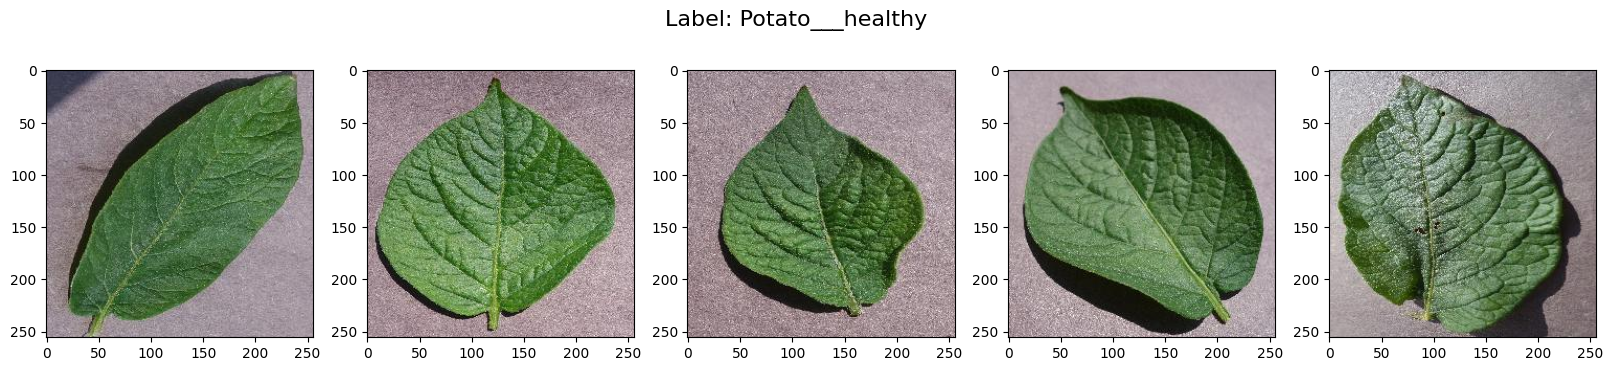

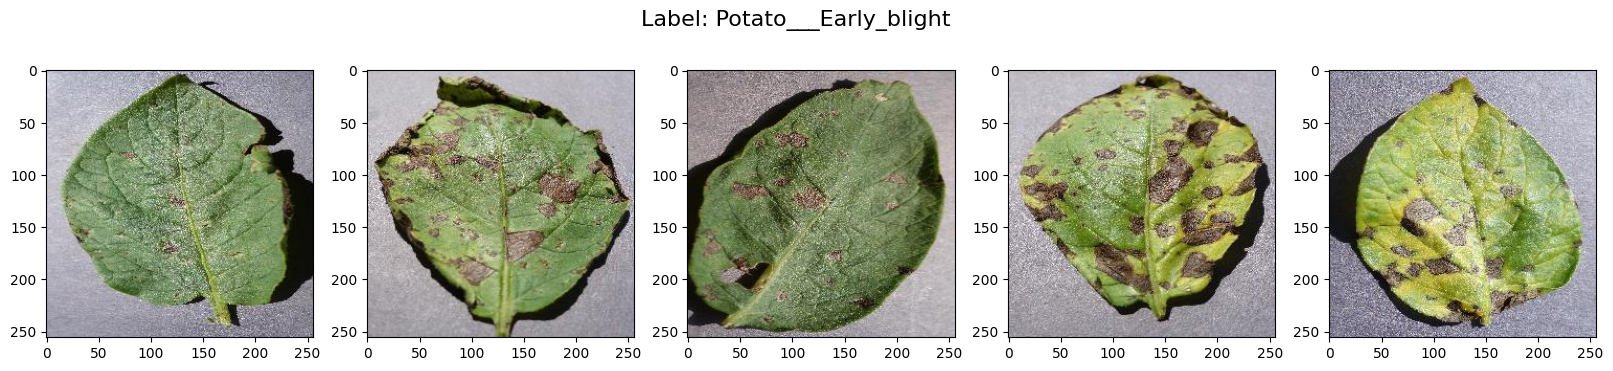

In [14]:
# Get the class labels from the training directory
class_labels = os.listdir(train_dir)

# Function to display samples
def show_samples(data_dir, class_labels):
    for label in class_labels:
        # Get the path to the class folder
        class_dir = os.path.join(data_dir, label)

        # List all images in the class folder
        class_images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Display the first 5 images
        plt.figure(figsize=(20, 4))  # Set the figure size for each label
        plt.suptitle(f"Label: {label}", fontsize=16)  # Add label title above the row

        for i, img_name in enumerate(class_images[:5]):
            # Load and display the image
            img_path = os.path.join(class_dir, img_name)
            img = mpimg.imread(img_path)

            # Add subplot for each image
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.axis('on')

        # Show the row of images for this label
        plt.show()

# Display samples from the training directory
show_samples(train_dir, class_labels)

In [15]:
def get_image_dimensions(image_path):
    """
    Gets the dimensions (width, height) of an image.

    Args:
        image_path: Path to the image file.

    Returns:
        Tuple: (width, height) of the image.
    """
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

all_dimensions = []

for class_label in class_labels:
    class_dir = os.path.join(train_dir, class_label)  # Use train_dir or any other directory
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        width, height = get_image_dimensions(image_path)
        all_dimensions.append((width, height))

# Convert dimensions to a NumPy array for easier analysis
all_dimensions = np.array(all_dimensions)

# Calculate min and max width and height
min_width = np.min(all_dimensions[:, 0])
max_width = np.max(all_dimensions[:, 0])
min_height = np.min(all_dimensions[:, 1])
max_height = np.max(all_dimensions[:, 1])

# Print the results
print(f"Minimum width: {min_width}")
print(f"Maximum width: {max_width}")
print(f"Minimum height: {min_height}")
print(f"Maximum height: {max_height}")

Minimum width: 256
Maximum width: 256
Minimum height: 256
Maximum height: 256


# Data Preparation

In [16]:
# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [17]:
# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical',
    seed=42
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical',
    seed=42
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical',
    seed=42
)

Found 1507 files belonging to 3 classes.
Found 430 files belonging to 3 classes.
Found 215 files belonging to 3 classes.


In [18]:
# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Model Architecture

In [19]:
# Load InceptionV3
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
pre_trained_model.trainable = False  # Freeze layers

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [21]:
# Extract features from `mixed8`
last_layer = pre_trained_model.get_layer('mixed8')
last_output = last_layer.output

In [28]:
# Build classifier
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)

# Assemble the model
model = models.Model(inputs=pre_trained_model.input, outputs=x)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 43,976,355 (167.76 MB)

 Trainable params: 33,298,435 (127.02 MB)

 Non-trainable params: 10,677,920 (40.73 MB)

In [29]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

In [30]:
# Combine augmentation with the model
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented_inputs = data_augmentation(inputs)
outputs = model(augmented_inputs)
model_with_aug = tf.keras.Model(inputs, outputs)

model_with_aug.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 3)                   │      43,976,355 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,976,355 (167.76 MB)

 Trainable params: 33,298,435 (127.02 MB)

 Non-trainable params: 10,677,920 (40.73 MB)

In [31]:
# Compile the model
base_learning_rate = 0.0001
model_with_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['accuracy'])

In [32]:
# Custom accuracy-based stopping
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_accuracy:  # Stop when target accuracy is reached
            print(f"\nReached {self.target_accuracy * 100}% accuracy. Stopping training!")
            self.model.stop_training = True

# Initialize callbacks
accuracy_callback = AccuracyThresholdCallback(target_accuracy=0.97)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [33]:
history = model_with_aug.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=2,
    callbacks=[accuracy_callback]
)

Epoch 1/20
24/24 - 25s - 1s/step - accuracy: 0.7206 - loss: 0.7628 - val_accuracy: 0.7814 - val_loss: 0.5571
Epoch 2/20
24/24 - 8s - 349ms/step - accuracy: 0.8872 - loss: 0.3187 - val_accuracy: 0.9326 - val_loss: 0.1916
Epoch 3/20
24/24 - 5s - 220ms/step - accuracy: 0.9124 - loss: 0.2490 - val_accuracy: 0.8860 - val_loss: 0.3033
Epoch 4/20
24/24 - 10s - 418ms/step - accuracy: 0.9343 - loss: 0.2008 - val_accuracy: 0.9349 - val_loss: 0.1578
Epoch 5/20
24/24 - 5s - 212ms/step - accuracy: 0.9423 - loss: 0.1709 - val_accuracy: 0.9674 - val_loss: 0.0976
Epoch 6/20
24/24 - 5s - 214ms/step - accuracy: 0.9502 - loss: 0.1426 - val_accuracy: 0.9698 - val_loss: 0.0940
Epoch 7/20
24/24 - 10s - 429ms/step - accuracy: 0.9562 - loss: 0.1218 - val_accuracy: 0.9279 - val_loss: 0.1829
Epoch 8/20
24/24 - 10s - 433ms/step - accuracy: 0.9522 - loss: 0.1380 - val_accuracy: 0.9884 - val_loss: 0.0603
Epoch 9/20
24/24 - 5s - 218ms/step - accuracy: 0.9555 - loss: 0.1339 - val_accuracy: 0.9488 - val_loss: 0.1356


# Evaluate Model

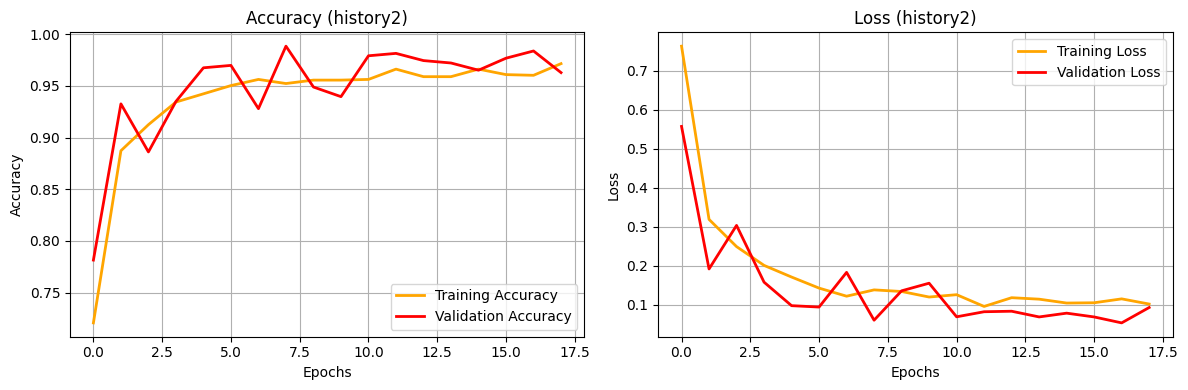

In [35]:
# Plot accuracy and loss for history2
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange', linestyle='-', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='r', linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy (history2)')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='r', linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss (history2)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_with_aug.evaluate(test_dataset, verbose=2)

# Print the test loss and accuracy
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f"Score: {test_accuracy * 100:.2f}%")

4/4 - 2s - 417ms/step - accuracy: 0.9488 - loss: 0.0894
Test Loss: 0.08940468728542328
Test Accuracy: 0.9488372206687927
Score: 94.88%


In [38]:
# Extract class names from the training directory structure
class_names = sorted(entry.name for entry in os.scandir(train_dir) if entry.is_dir())

print("Class names:", class_names)

Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


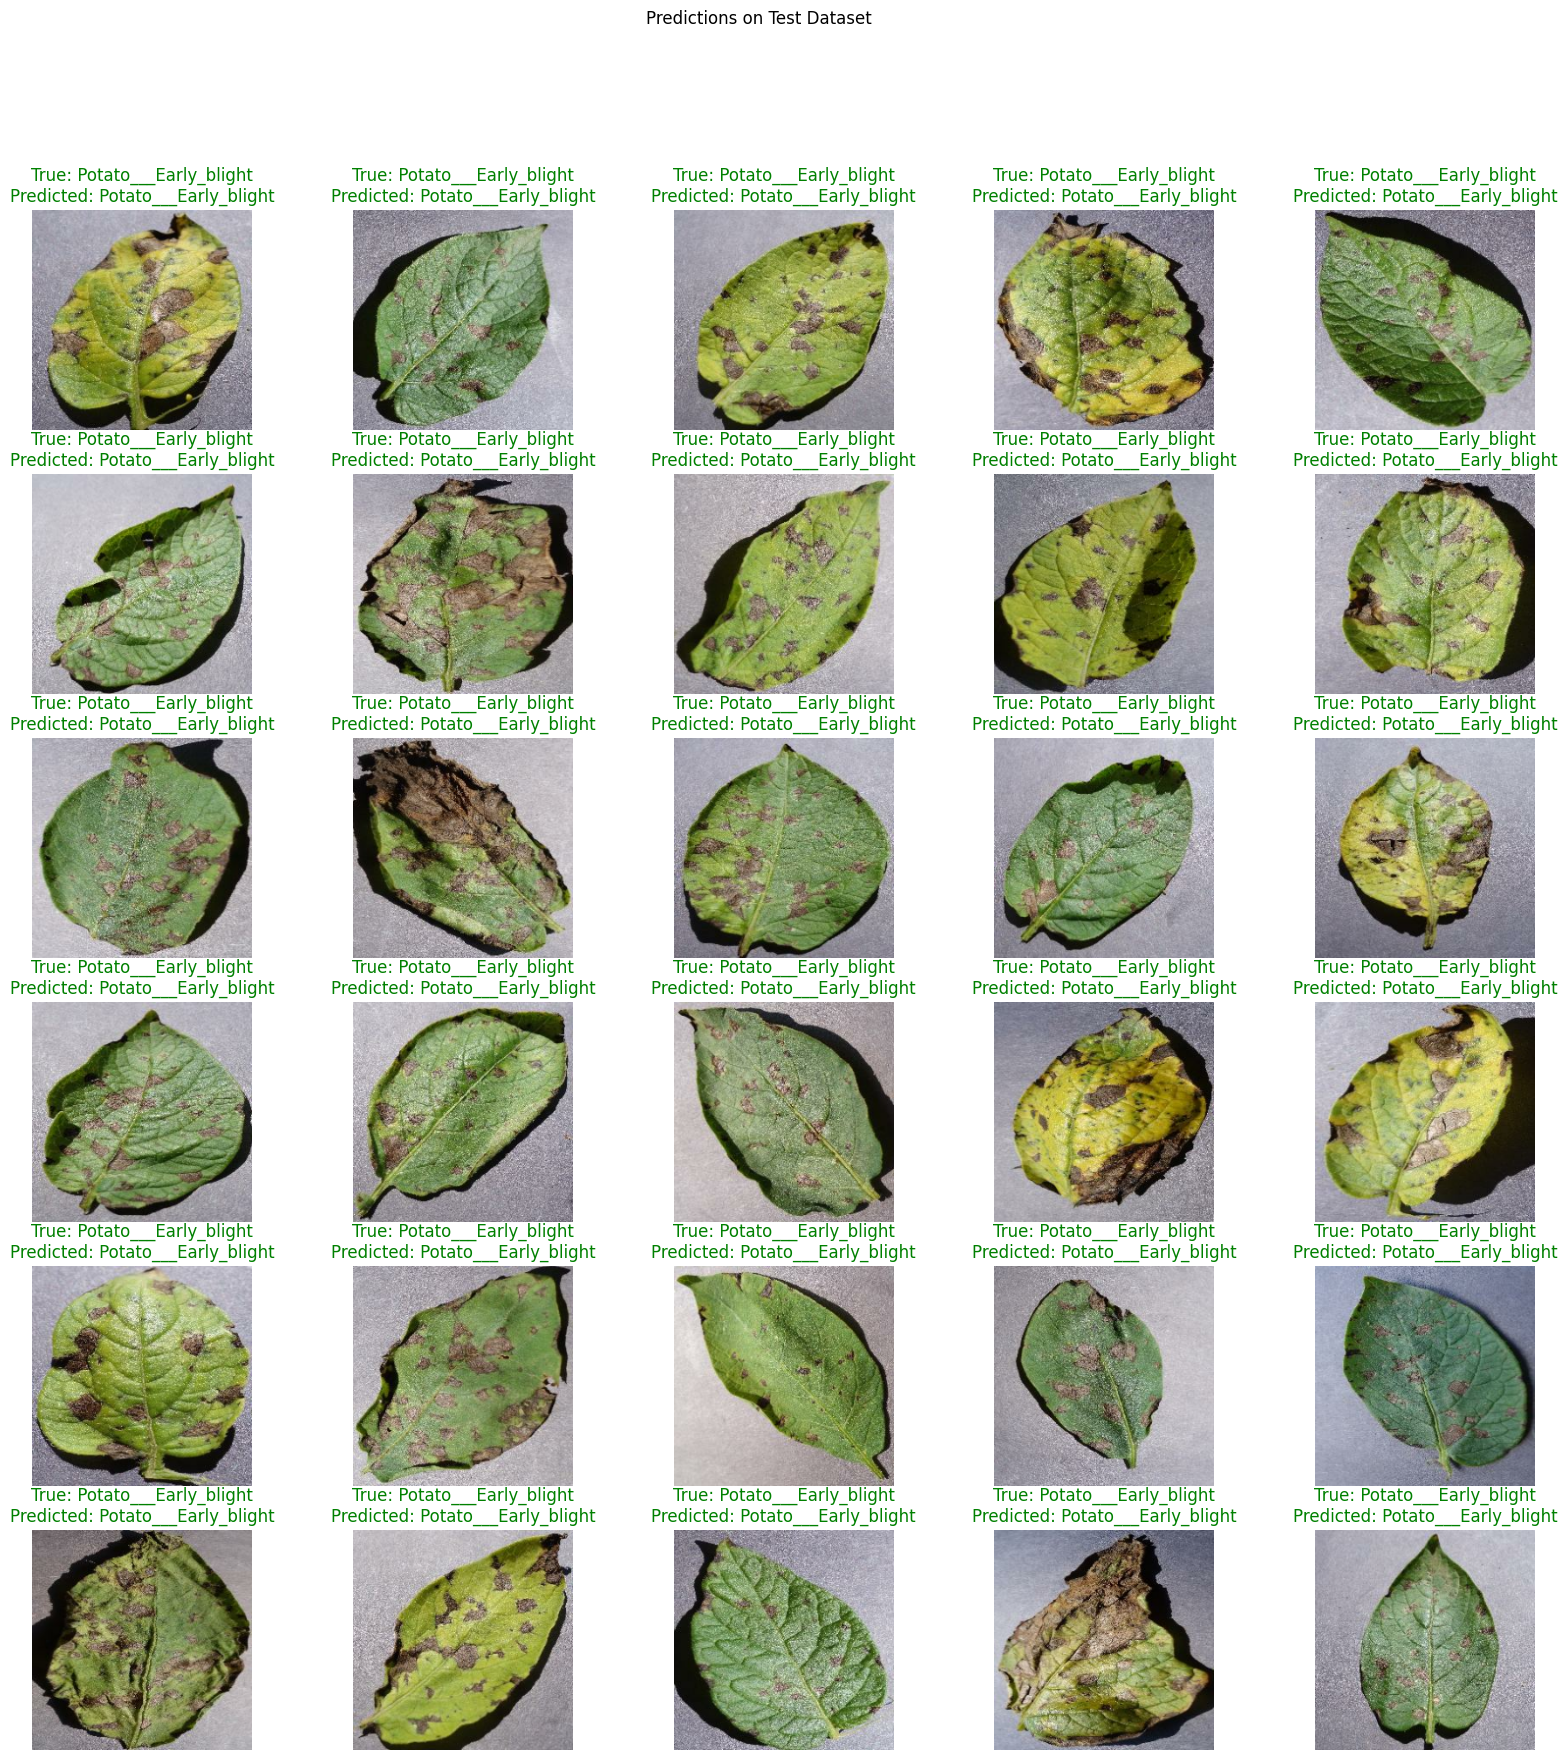

In [41]:
# Function to extract class names from the directory structure
def get_class_names_from_directory(directory):
    return sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

# Extract class names dynamically from the train directory
class_names = get_class_names_from_directory(train_dir)

# Function to get predictions and visualize
def get_predictions_and_visualize(model, test_dataset, class_names, max_images=30):
    all_true_labels = []
    all_predicted_labels = []
    all_images = []

    # Iterate through batches in the test set
    for image_batch, label_batch in test_dataset:
        # Make predictions on the batch
        predictions = model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # Append the image batch, true labels, and predicted labels
        all_images.extend(image_batch.numpy())  # Convert tensor to numpy array
        all_true_labels.extend(np.argmax(label_batch, axis=1))  # Convert one-hot encoded labels to class indices
        all_predicted_labels.extend(predicted_labels)

        # Check how many images we've processed, stop after max_images
        if len(all_images) >= max_images:
            break

    # Plot the predictions
    plt.figure(figsize=(20, 20))
    plt.suptitle('Predictions on Test Dataset')

    for i in range(min(max_images, len(all_images))):
        ax = plt.subplot(6, 5, i + 1)  # 6 rows, 5 columns of subplots
        color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'

        # Display the image
        plt.imshow(all_images[i].astype("uint8"))
        plt.axis('off')

        # Display the true and predicted class names using the correct class_names
        true_label_name = class_names[all_true_labels[i]]
        predicted_label_name = class_names[all_predicted_labels[i]]

        plt.title(f'True: {true_label_name}\nPredicted: {predicted_label_name}', color=color)

    plt.show()

# Example usage
get_predictions_and_visualize(model_with_aug, test_dataset, class_names)

In [42]:
for image_batch, label_batch in test_dataset:
    print("Batch label distribution:", np.bincount(np.argmax(label_batch, axis=1)))
    break  # Just to check one batch

Batch label distribution: [64]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


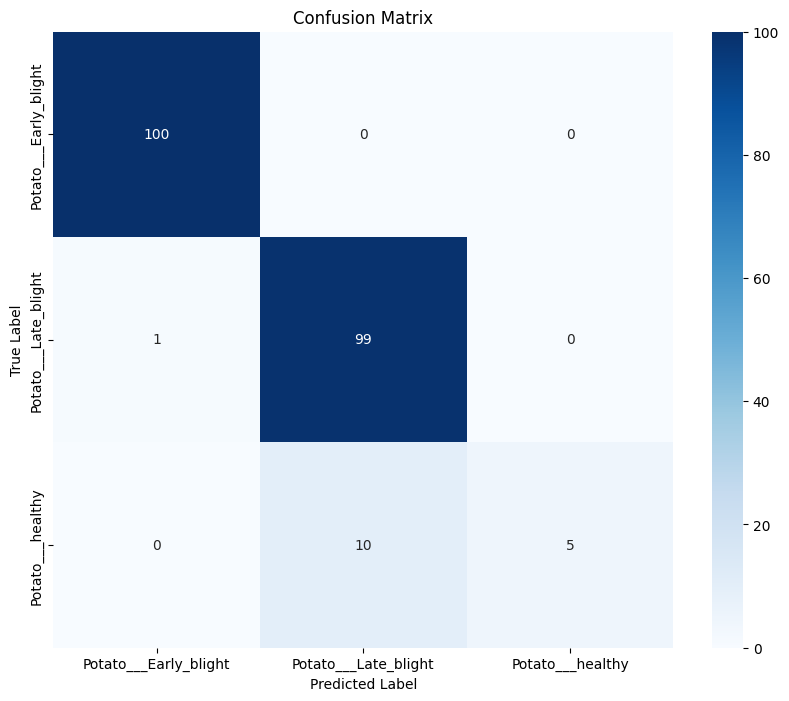

In [44]:
# Function to compute and plot confusion matrix
def eval_CM(y_true, y_pred, labels):
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to get true and predicted labels from the entire test dataset
def get_true_and_predicted_labels(model, test_dataset, class_names): # Changed disease_labels to class_names
    all_true_labels = []
    all_predicted_labels = []

    # Iterate through batches in the test dataset
    for image_batch, label_batch in test_dataset:
        # Make predictions on the batch
        predictions = model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # Append the true labels and predicted labels
        all_true_labels.extend(np.argmax(label_batch, axis=1))  # Convert one-hot encoded labels to class indices
        all_predicted_labels.extend(predicted_labels)

    return all_true_labels, all_predicted_labels

# Get true and predicted labels from the entire test dataset
# Assuming class_names has been extracted in a previous cell
y_true, y_pred = get_true_and_predicted_labels(model_with_aug, test_dataset, class_names) # Changed disease_labels to class_names

# Call the eval_CM function to display the confusion matrix
eval_CM(y_true, y_pred, class_names) # Changed disease_labels to class_names

In [45]:
# Save the model to the specified path
model.save("/content/drive/MyDrive/Capstone/InceptionV3_model/Corn_InceptionV3.h5")
print("Model saved successfully to Google Drive!")

Model saved successfully to Google Drive!
